In [1]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors, patches
from tqdm.notebook import tqdm
import colorcet as cc

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [12]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

## Massive type IIA on $S^3\times S^3$

#### Parameter scan to identify interesting region of the ($u_0,\phi_0$) plane

100%|██████████| 400/400 [00:09<00:00, 43.35it/s]


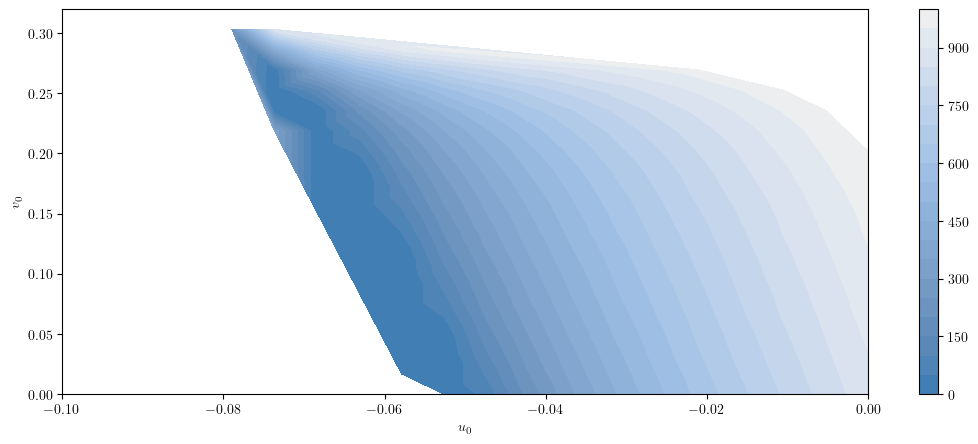

In [18]:
q0 = 1
rmax = 10*q0
u0_list = np.linspace(-0.1, 0, 20)
φ0_list = np.linspace(0, 0.32, 20)

scanData = wh.paramScan_S3S3(q0, u0_list, φ0_list, rmax)

plotData = scanData[:, scanData[2] < 1000]

fig, ax = plt.subplots(1, 1, figsize=(13, 5))
im = plt.tricontourf(plotData[0], plotData[1], plotData[2],
                     levels=20,
                     cmap='cet_CET_L12_r',
                     origin='lower',
                     extent=(u0_list[0], u0_list[-1], φ0_list[0], φ0_list[-1])
                    )

plt.xlim(u0_list[0], u0_list[-1])
plt.ylim(φ0_list[0], φ0_list[-1])

plt.xlabel('$u_0$')
plt.ylabel('$v_0$')

plt.colorbar(im)

plt.show()

#### Optimal solution matching AdS boundary conditions is found using shooting method

(q0,rmax,fev) = (1.0000,   2, 279)    (u0,φ0) = (-0.0788121837010492, +0.2930739435399038)    val = 0.0
(q0,rmax,fev) = (1.0000,   4, 214)    (u0,φ0) = (-0.0789175041946376, +0.2943047806474781)    val = 0.0
(q0,rmax,fev) = (1.0000,   8, 252)    (u0,φ0) = (-0.0789187184684953, +0.2943214689778818)    val = 0.0
(q0,rmax,fev) = (1.0000,  16, 219)    (u0,φ0) = (-0.0789187268770891, +0.2943215889023439)    val = 0.0
(q0,rmax,fev) = (1.0000,  32, 225)    (u0,φ0) = (-0.0789187269321844, +0.2943215896889758)    val = 0.0
(q0,rmax,fev) = (1.0000,32.0000, 225)    (u0,φ0,uf,φf) = (-0.0789187269321844, +0.2943215896889758, -0.0000000299147014, +0.0000003147412915)



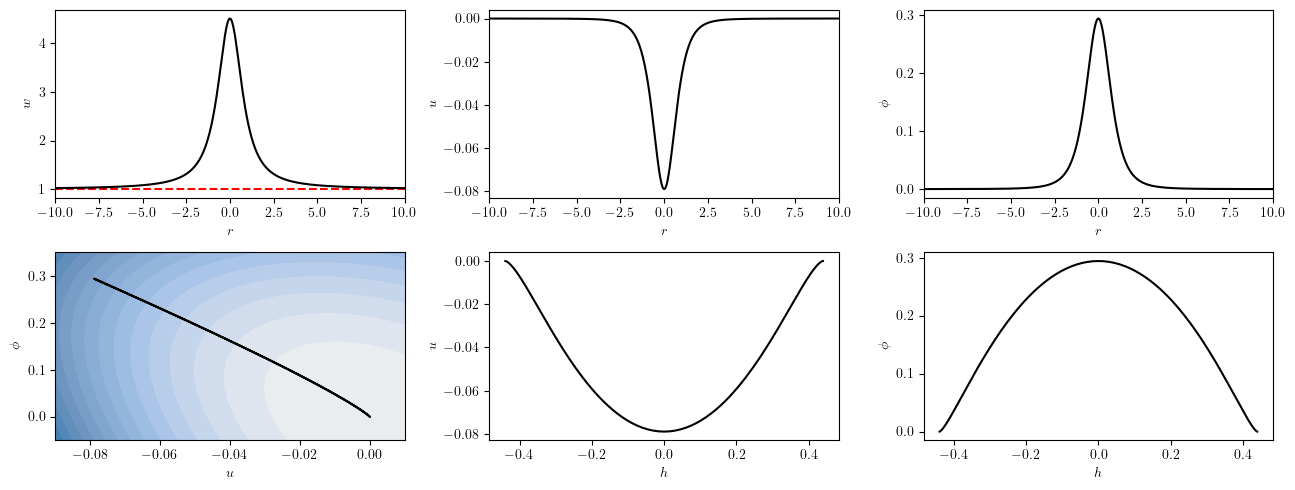

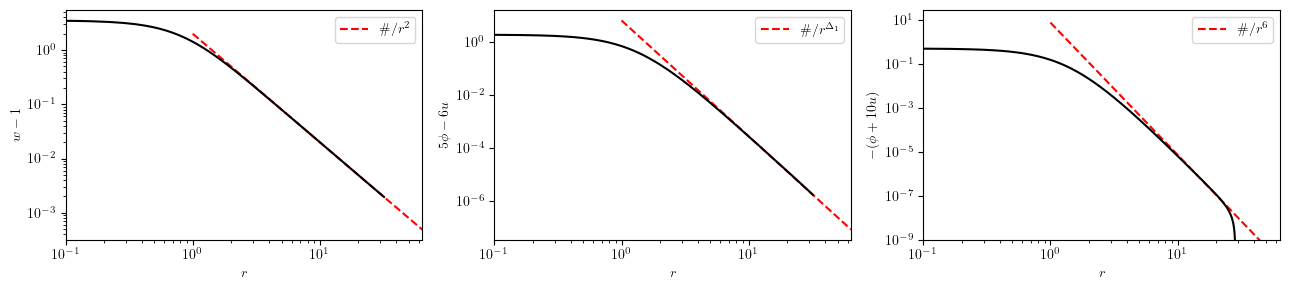

In [47]:
q0 = 1
rmax_list = [2, 4, 8, 16, 32]
soln = wh.wormhole_S3S3(q0, rmax_list)
r, w, u, ud, φ, φd, h, f4sqr = soln

fig, axes = plt.subplots(2, 3, figsize=(13, 5))

axes[0,0].axhline(1, ls='--', c='r')

xdata = [r, r, r, u, h, h]
ydata = [w, u, φ, φ, u, φ]
xlabels = ['$r$', '$r$', '$r$', '$u$', '$h$', '$h$']
ylabels = ['$w$', '$u$', '$\phi$', '$\phi$', '$u$', '$\phi$']

for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

for ax in axes[0]:
    ax.set_xlim(-10, 10)

u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[1,0].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(φ0s[0], φ0s[-1])

plt.tight_layout()
plt.show()




fig, axes = plt.subplots(1, 3, figsize=(13,3))

Δ1 = (3+np.sqrt(33))/2
wcoeff = np.mean(r[-10:]**2 * (w[-10:] - 1))
uφcoeff1 = np.mean(r[-10:]**Δ1 * (5*φ[-10:] - 6*u[-10:]))
mask2 = (r > 10) * (r < 20)
uφcoeff2 = np.mean(r[mask2]**6 * (-φ[mask2] - 10*u[mask2]))

rr = np.linspace(q0, 2*rmax_list[-1], 2)
axes[0].plot(rr, wcoeff/rr**2, '--r', label='$\#/r^2$')
axes[1].plot(rr, uφcoeff1/rr**Δ1, '--r', label='$\#/r^{\Delta_1}$')
axes[2].plot(rr, uφcoeff2/rr**6, '--r', label='$\#/r^6$')

axes[0].plot(r, w-1, 'k')
axes[1].plot(r, 5*φ-6*u, 'k')
axes[2].plot(r, -(φ+10*u), 'k')

axes[0].set_ylabel('$w-1$')
axes[1].set_ylabel('$5\phi-6u$')
axes[2].set_ylabel('$-(\phi+10u)$')

for ax in axes:
    ax.set_xlim(0.1*q0, 2*rmax_list[-1])
    ax.set_xlabel('$r$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

axes[2].set_ylim(10**-9)

plt.tight_layout()
plt.show()

#### Field ranges

In [69]:
def h_infty_massless(q0, qmax, dq):

    q = np.arange(q0, qmax, dq)[1:]
    integrand = q**-3 * (1 + q**2 - q0**4 * (1+q0**2)/q**4)**(-1/2)

    return sum(dq*integrand)

In [75]:
q0s = np.geomspace(0.0005, 10, 20)

data = []

for q0 in q0s:

    soln = wh.wormhole_S3S3(q0, [4*q0, 8*q0, 16*q0, 32*q0], xatol=10**-16)
    r, w, u, ud, φ, φd, h, f4sqr = soln

    data.append([np.sqrt(f4sqr), min(u), max(φ)])

f4s, u0s, φ0s = np.asarray(data).T

(q0,rmax,fev) = (0.0005,   0, 298)    (u0,φ0) = (-0.7085150219849667, +1.4350057912728866)    val = 0.0
(q0,rmax,fev) = (0.0005,   0,1000)    (u0,φ0) = (-0.7627897383461214, +1.5315704001524229)    val = 0.0
(q0,rmax,fev) = (0.0005,   0,1000)    (u0,φ0) = (-0.7775719215044108, +1.5569949849123137)    val = 0.0
(q0,rmax,fev) = (0.0005,   0,1000)    (u0,φ0) = (-0.7813414847582295, +1.5634081682970129)    val = 0.0
(q0,rmax,fev) = (0.0005,0.0160,1000)    (u0,φ0,uf,φf) = (-0.7813414847582295, +1.5634081682970129, -0.0007036421140187, +0.0017986813565321)

(q0,rmax,fev) = (0.0008,   0,1000)    (u0,φ0) = (-0.7082287942815276, +1.4347147920358108)    val = 0.0
(q0,rmax,fev) = (0.0008,   0,1000)    (u0,φ0) = (-0.7622785123043460, +1.5310364296053720)    val = 0.0
(q0,rmax,fev) = (0.0008,   0,1000)    (u0,φ0) = (-0.7769697680873181, +1.5563673379750729)    val = 0.0
(q0,rmax,fev) = (0.0008,   0, 213)    (u0,φ0) = (-0.7807094362668263, +1.5627534920099131)    val = 0.0
(q0,rmax,fev) = (0.0008,0.

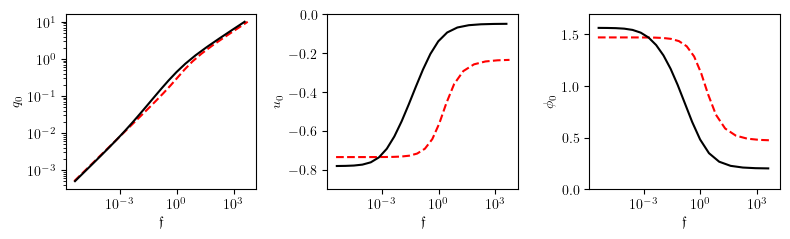

In [80]:
q0_massless = np.geomspace(0.0005, 10, 21)
hinf_massless = np.asarray([h_infty_massless(q0, 10*q0, q0/10000) for q0 in q0_massless])
cabs_massless = 12*q0_massless**4 * (1+q0_massless**2)
f4_massless = np.sqrt(cabs_massless) / np.cos(0.5 * np.sqrt(cabs_massless) * hinf_massless)
φ0_massless = -np.log(np.cos(0.5 * np.sqrt(cabs_massless) * hinf_massless))
u0_massless = -0.5*φ0_massless



fig, axes = plt.subplots(1, 3, figsize=(8,2.5))

axes[0].plot(f4_massless, q0_massless, '--r')
axes[0].plot(f4s, q0s, 'k', ms=3)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('$\mathfrak{f}$')
axes[0].set_ylabel('$q_0$')

axes[1].plot(f4_massless, u0_massless, '--r')
axes[1].plot(f4s, u0s, 'k', ms=3)
axes[1].set_xscale('log')
axes[1].set_xlabel('$\mathfrak{f}$')
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)


axes[2].plot(f4_massless, φ0_massless, '--r')
axes[2].plot(f4s, φ0s, 'k', ms=3)
axes[2].set_xscale('log')
axes[2].set_xlabel('$\mathfrak{f}$')
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.tight_layout()
# plt.savefig('S3S3_ranges.png', dpi=300)
plt.show()

## Type IIB on $T^{1,1}$

#### Parameter scan to identify interesting region of the ($u_0,v_0$) plane

100%|██████████| 400/400 [00:32<00:00, 12.46it/s]


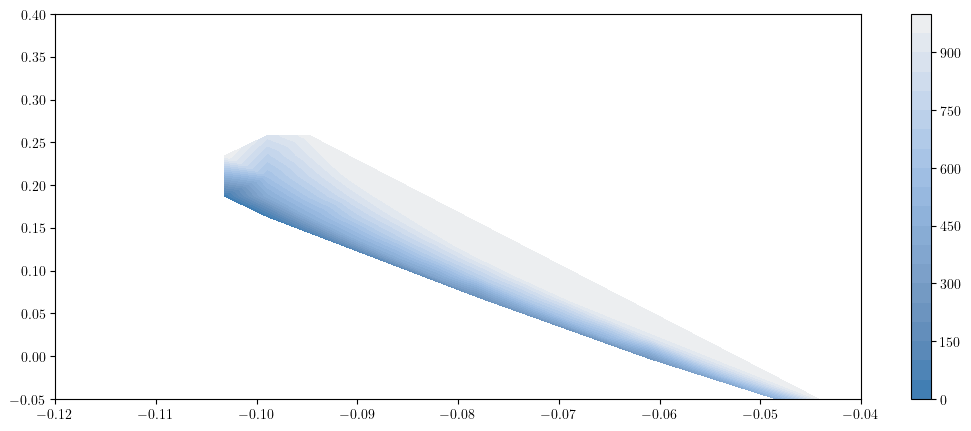

In [84]:
q0 = 1
rmax = 10
u0_list = np.linspace(-0.12, -0.04, 20)
v0_list = np.linspace(-0.05, 0.4, 20)

scanData = wh.paramScan_T11(q0, u0_list, v0_list, rmax)

plotData = scanData[:, scanData[2] < 1000]

fig, ax = plt.subplots(1, 1, figsize=(13, 5))
im = plt.tricontourf(plotData[0], plotData[1], plotData[2],
                     levels=20,
                     cmap='cet_CET_L12_r',
                     origin='lower',
                     extent=(u0_list[0], u0_list[-1], v0_list[0], v0_list[-1])
                    )

plt.xlim(u0_list[0], u0_list[-1])
plt.ylim(v0_list[0], v0_list[-1])

plt.colorbar(im)

plt.show()

#### Optimal solution matching AdS boundary conditions is found using shooting method

(q0,rmax,fev) = (1.0000,   4, 319)    (u0,v0) = (-0.1030303035680072, +0.1826778177747937)    val = 0.0
(q0,rmax,fev) = (1.0000,   8, 215)    (u0,v0) = (-0.1030305478779181, +0.1826791707158280)    val = 0.0
(q0,rmax,fev) = (1.0000,  16, 205)    (u0,v0) = (-0.1030305478775007, +0.1826791707224705)    val = 6.377121053446899e-13
(q0,rmax,fev) = (1.0000,  16, 205)    (u0,v0,uf,vf) = (-0.1030305478775007, +0.1826791707224705, +0.0000004499851002, -0.0000003919873408)



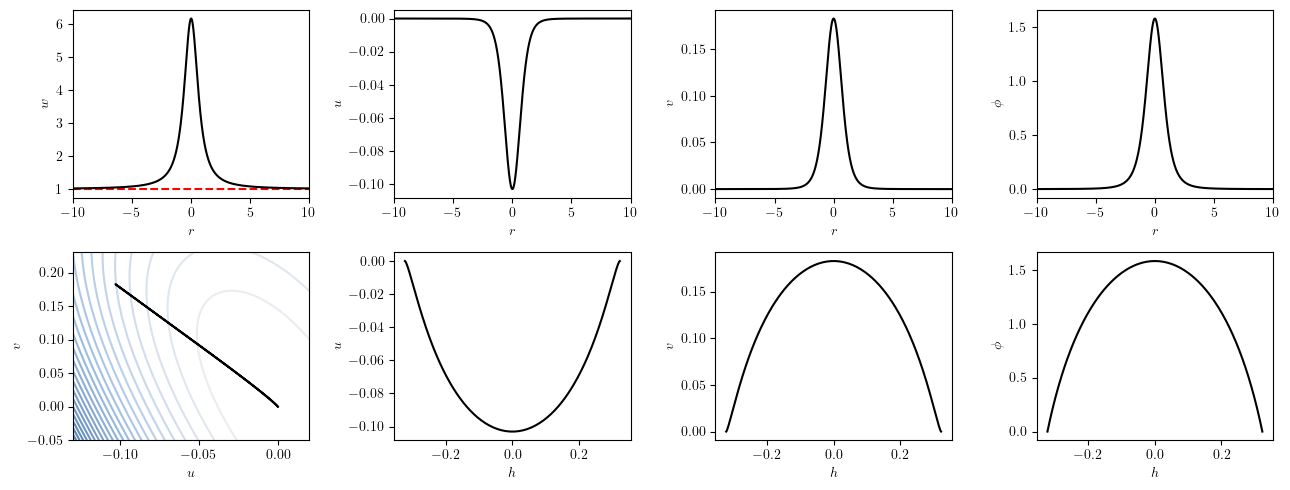

In [92]:
q0 = 1
rmax_list = [4, 8, 16]
soln = wh.wormhole_T11(q0, rmax_list)

r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

fig, axes = plt.subplots(2, 4, figsize=(13, 5))

axes[0,0].axhline(1, ls='--', c='r')

u0s = np.linspace(-0.13, 0.02, 40)
v0s = np.linspace(-0.05, 0.23, 40)
umesh, vmesh = np.meshgrid(u0s, v0s)
VV = wh.V_T11(umesh, vmesh)

axes[1,0].contour(umesh, vmesh, VV,
                   levels=np.arange(-12, 1, 0.5),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], v0s[0], v0s[-1])
                  )

xdata_list = [r, r, r, r, u, h, h, h]
ydata_list = [w, u, v, φ, v, u, v, φ]
xlabels = ['$r$', '$r$', '$r$', '$r$', '$u$', '$h$', '$h$', '$h$']
ylabels = ['$w$', '$u$', '$v$', '$\phi$', '$v$', '$u$', '$v$', '$\phi$']

for ax, xdata, ydata, xlabel, ylabel in zip(axes.ravel(), xdata_list, ydata_list, xlabels, ylabels):
    ax.plot(xdata, ydata, 'k')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

for ax in axes[0]:
    ax.set_xlim(-10, 10)


axes[1,0].set_xlim(u0s[0], u0s[-1])
axes[1,0].set_ylim(v0s[0], v0s[-1])


plt.tight_layout()
# plt.savefig('T11_profiles_ex1.png', dpi=300)
plt.show()

In [30]:
q0 = 3
rmax_list = q0 * np.asarray([2, 4, 8, 16, 32, 64])

solns = []

for ii in range(len(rmax_list)):
    soln = wh.wormhole_T11(q0, rmax_list[:(ii+1)], xatol=10**-20, nr=10000)
    solns.append(soln)

(q0,rmax,fev) = (3.0000,   6, 282)    (u0,v0) = (-0.0718577743315988, +0.1305441863457987)    val = 0.0
(q0,rmax,fev) = (3.0000,   6, 282)    (u0,v0,uf,vf) = (-0.0718577743315988, +0.1305441863457987, -0.0014188907269760, +0.0033945259902638)

(q0,rmax,fev) = (3.0000,   6, 282)    (u0,v0) = (-0.0718577743315988, +0.1305441863457987)    val = 0.0
(q0,rmax,fev) = (3.0000,  12,1000)    (u0,v0) = (-0.0718816178004670, +0.1306570176515669)    val = 0.0
(q0,rmax,fev) = (3.0000,  12,1000)    (u0,v0,uf,vf) = (-0.0718816178004670, +0.1306570176515669, -0.0000459464757197, +0.0001410468684274)

(q0,rmax,fev) = (3.0000,   6, 282)    (u0,v0) = (-0.0718577743315988, +0.1305441863457987)    val = 0.0
(q0,rmax,fev) = (3.0000,  12,1000)    (u0,v0) = (-0.0718816178004670, +0.1306570176515669)    val = 0.0
(q0,rmax,fev) = (3.0000,  24,1000)    (u0,v0) = (-0.0718816855713164, +0.1306573627360895)    val = 0.0
(q0,rmax,fev) = (3.0000,  24,1000)    (u0,v0,uf,vf) = (-0.0718816855713164, +0.1306573627360895,

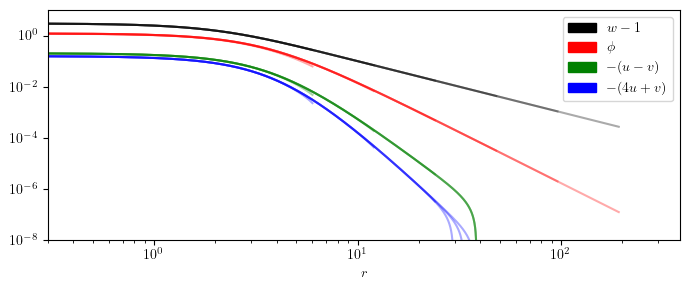

In [70]:
r, w, u, ud, v, vd, φ, φd, h, f3sqr = solns[-1]
wcoeff = np.mean(r[-10:]**2 * (w[-10:] - 1))
mask1 = (r > 5) * (r < 30)
uvcoeff1 = np.mean(r[mask1]**6 * (-u[mask1]+v[mask1]))
mask2 = (r > 5) * (r < 20)
uvcoeff2 = np.mean(r[mask2]**8 * (-4*u[mask2]-v[mask2]))
φcoeff = np.mean(r[-10:]**4 * φ[-10:])

fig, ax = plt.subplots(1, 1, figsize=(7,3))

# rr = np.linspace(q0/2, 2*rmax_list[-1], 100)
# plt.plot(rr, wcoeff/rr**2, '--r', label='$10/r^2$')
# plt.plot(rr, uvcoeff1/rr**6, '--r', label='$100/r^6$')
# plt.plot(rr, uvcoeff2/rr**8, '--r', label='$100/r^8$')
# plt.plot(rr, φcoeff/rr**4, '--r', label='$100/r^4$')

alpha = 2/len(solns)
# alpha = 1

for soln in solns:  
    r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

    plt.plot(r, w-1,      'k', alpha=alpha)
    plt.plot(r, φ,        'r', alpha=alpha)
    plt.plot(r, -(u-v),   'g', alpha=alpha)
    plt.plot(r, -(4*u+v), 'b', alpha=alpha)

plt.xlim(0.1*q0, 2*rmax_list[-1])
plt.ylim(10**-8, 10)
plt.xlabel('$r$')
plt.xscale('log')
plt.yscale('log')

label1 = patches.Patch(color='k', label='$w-1$')
label2 = patches.Patch(color='r', label='$\phi$')
label3 = patches.Patch(color='g', label='$-(u-v)$')
label4 = patches.Patch(color='b', label='$-(4u+v)$')
plt.legend(handles=[label1, label2, label3, label4])

plt.tight_layout()

# plt.savefig('T11_converge_ex1.png', dpi=300)
plt.show()

#### Field ranges and BPS bound

In [94]:
def T11_massless_ranges(q0, qmax, dq):

    # Taking h(0) = 0, first compute h(inf)
    qs = np.arange(q0, qmax, dq)[1:]
    integrand = qs**-4 * (1 + qs**2 - q0**6 * (1+q0**2) / qs**6)**(-1/2)
    h_inf = sum(dq * integrand)

    # -c = 24*q0**6 * (1 + q0**2)
    c_abs = 24*q0**6 * (1 + q0**2)

    # φ = -4u = 4v has profile exp(φ) = cos(sqrt(-c/2)*h) / cos(sqrt(-c/2)*hinf),
    #   so φ(0) = -log[cos(sqrt(-c/2)*hinf)]
    φ0 = -np.log(np.cos(np.sqrt(c_abs/2) * h_inf))
    u0 = -φ0/4
    v0 = φ0/4

    f3 = np.sqrt(c_abs) / np.cos(np.sqrt(c_abs/2) * h_inf)

    return [f3, u0, v0, φ0]

def T11_frozen_ranges(q0, qmax, dq):

    # Taking h(0) = 0, first compute h(inf)
    qs = np.arange(q0, qmax, dq)[1:]
    integrand = qs**-4 * (1 + qs**2 - q0**6 * (1+q0**2) / qs**6)**(-1/2)
    h_inf = sum(dq * integrand)

    # -c = 24*q0**6 * (1 + q0**2)
    c_abs = 24*q0**6 * (1 + q0**2)

    # u=v=0 and exp(φ/2) = cos(0.5*sqrt(-c)*h) / cos(0.5*sqrt(-c)*hinf),
    #   so φ(0) = -2*log[cos(0.5*sqrt(-c)*hinf)]
    φ0 = -2*np.log(np.cos(0.5*np.sqrt(c_abs) * h_inf))

    f3 = np.sqrt(c_abs) / np.cos(0.5*np.sqrt(c_abs) * h_inf)

    return [f3, φ0]

In [171]:
q0s = np.geomspace(0.01, 10, 10)

data = []

for q0 in q0s:

    kmax = int(np.log(40/q0)/np.log(4)) + 1
    print(q0, kmax, q0*4**kmax)
    rmax_list = [q0*4**k for k in np.arange(0, kmax+0.01, 1)]

    soln = wh.wormhole_T11(q0, rmax_list, xatol=10**-10)
    r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

    data.append([np.sqrt(f3sqr),
                 min(u), max(v), max(φ),
                 np.mean(r[-10:]**4 * φ[-10:]), np.mean(r[-10:]**5 * φd[-10:] / (-4))
                ])

f3s, u0s, v0s, φ0s, φ4s, φ4s_alt = np.asarray(data).T

0.01 6 40.96
(q0,rmax,fev) = (0.0100,   0, 194)    (u0,v0) = (-0.5541094529679680, +0.5858759413846686)    val = 0.0
(q0,rmax,fev) = (0.0100,   0, 276)    (u0,v0) = (-1.0057596216474254, +1.2475029767852632)    val = 0.0
(q0,rmax,fev) = (0.0100,   0, 156)    (u0,v0) = (-1.0080208919602958, +1.2568980131237202)    val = 0.0
(q0,rmax,fev) = (0.0100,   1, 139)    (u0,v0) = (-1.0080509550725396, +1.2572077649023377)    val = 0.0
(q0,rmax,fev) = (0.0100,   3, 213)    (u0,v0) = (-1.0080510915437069, +1.2572103293497459)    val = 0.0
(q0,rmax,fev) = (0.0100,  10, 163)    (u0,v0) = (-1.0080510915437069, +1.2572103293497459)    val = 1.681099703887412e-12
(q0,rmax,fev) = (0.0100,  41, 204)    (u0,v0) = (-1.0080510915437069, +1.2572103293497459)    val = 1.108285964113165e-07
(q0,rmax,fev) = (0.0100,  41, 204)    (u0,v0,uf,vf) = (-1.0080510915437069, +1.2572103293497459, -0.0001328898089207, -0.0001325005226607)

0.021544346900318832 6 88.24564490370594
(q0,rmax,fev) = (0.0215,   0, 200)    (u0,

In [172]:
q0_massless = np.geomspace(0.7727, 10, 100)
data_massless = [T11_massless_ranges(q0, 10*q0, 0.001*q0) for q0 in q0_massless]
f3_massless, u0_massless, v0_massless, φ0_massless = np.asarray(data_massless).T
f3_massless = [f3_massless[0], *f3_massless]
u0_massless = [-10, *u0_massless]
v0_massless = [10, *v0_massless]
φ0_massless = [10, *φ0_massless]

q0_frozen = np.geomspace(0.01, 10, 100)
data_frozen = [T11_frozen_ranges(q0, 10*q0, 0.001*q0) for q0 in q0_frozen]
f3_frozen, φ0_frozen = np.asarray(data_frozen).T

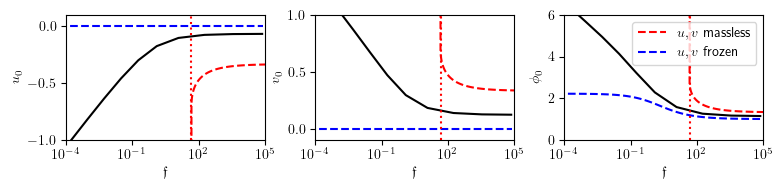

In [206]:
fig, axes = plt.subplots(1, 3, figsize=(8,2))

axes[0].plot(f3_massless, u0_massless, '--r')
axes[0].plot(f3_frozen,   0*f3_frozen, '--b')
axes[0].plot(f3s, u0s, 'k')

axes[1].plot(f3_massless, v0_massless, '--r')
axes[1].plot(f3_frozen,   0*f3_frozen, '--b')
axes[1].plot(f3s, v0s, 'k')

axes[2].plot(f3_massless, φ0_massless, '--r', label='$u,v$ massless')
axes[2].plot(f3_frozen,   φ0_frozen,   '--b', label='$u,v$ frozen')
axes[2].plot(f3s, φ0s, 'k')

for ax, ylab in zip(axes, ['$u_0$', '$v_0$', '$\phi_0$']):
    ax.axvline(min(f3_massless), ls=':', c='r')
    ax.set_xlim(10**-4, 10**5)
    ax.set_xscale('log')
    ax.set_xlabel('$\mathfrak{f}$')
    ax.set_ylabel(ylab)

axes[0].set_ylim(-1, 0.1)
axes[1].set_ylim(-0.1, 1)
axes[2].set_ylim(0, 6)

axes[2].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('T11_ranges.png', dpi=300)
plt.show()

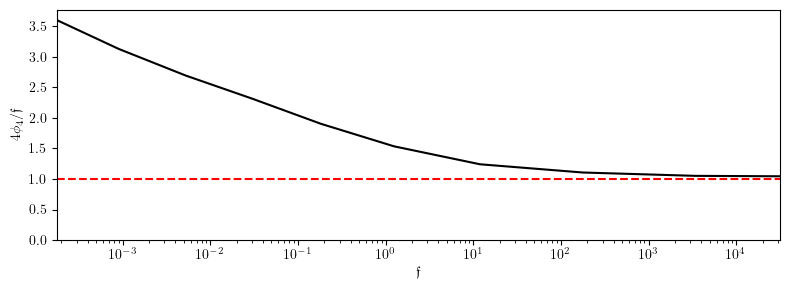

In [212]:
fig, ax = plt.subplots(1, 1, figsize=(8,3))

plt.axhline(1, ls='--', c='r')

plt.plot(f3s, 4*φ4s/f3s, 'k')
# plt.plot(f3s, 4*φ4s_alt/f3s, 'b')

plt.xlim(10**-3.75, 10**4.5)
plt.ylim(0)

plt.xscale('log')
plt.xlabel('$\mathfrak{f}$')
plt.ylabel('$4\phi_4/\mathfrak{f}$')

plt.tight_layout()
# plt.savefig('T11_BPS.png', dpi=300)
plt.show()

In [161]:
q0 = 0.01
rmax_list = [q0*m for m in [1, 4, 16, 64, 256, 1024]]

soln = wh.wormhole_T11(q0, rmax_list, xatol=10**-10)
r, w, u, ud, v, vd, φ, φd, h, f3sqr = soln

(q0,rmax,fev) = (0.0100,   0, 194)    (u0,v0) = (-0.5541094529679680, +0.5858759413846686)    val = 0.0
(q0,rmax,fev) = (0.0100,   0, 276)    (u0,v0) = (-1.0057596216474254, +1.2475029767852632)    val = 0.0
(q0,rmax,fev) = (0.0100,   0, 156)    (u0,v0) = (-1.0080208919602958, +1.2568980131237202)    val = 0.0
(q0,rmax,fev) = (0.0100,   1, 139)    (u0,v0) = (-1.0080509550725396, +1.2572077649023377)    val = 0.0
(q0,rmax,fev) = (0.0100,   3, 213)    (u0,v0) = (-1.0080510915437069, +1.2572103293497459)    val = 0.0
(q0,rmax,fev) = (0.0100,  10, 163)    (u0,v0) = (-1.0080510915437069, +1.2572103293497459)    val = 1.681099703887412e-12
(q0,rmax,fev) = (0.0100,  10, 163)    (u0,v0,uf,vf) = (-1.0080510915437069, +1.2572103293497459, -0.0000005298441821, -0.0000005053122933)



0.00014329024160650506 0.00015856559387520034 3.61466161995476


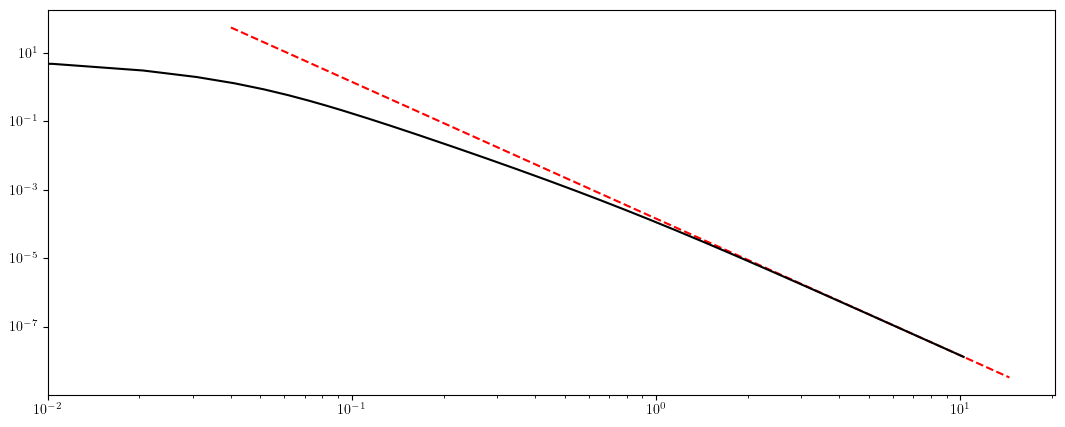

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

φcoeff = np.mean(r[-10:]**4 * φ[-10:])
print(φcoeff, np.sqrt(f3sqr), 4*φcoeff/np.sqrt(f3sqr))

rr = np.geomspace(4*q0, 1.414*rmax_list[-1], 10)
plt.plot(rr, φcoeff/rr**4, '--r')

# plt.plot(r, -u, 'k')
plt.plot(r, φ, 'k')

plt.xlim(q0, 2*rmax_list[-1])
# plt.ylim(10**-8, 10)
plt.xscale('log')
plt.yscale('log')

plt.show()